# N:1 MENT — marginal projections

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.train.plot import Plotter
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj1D
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian-mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

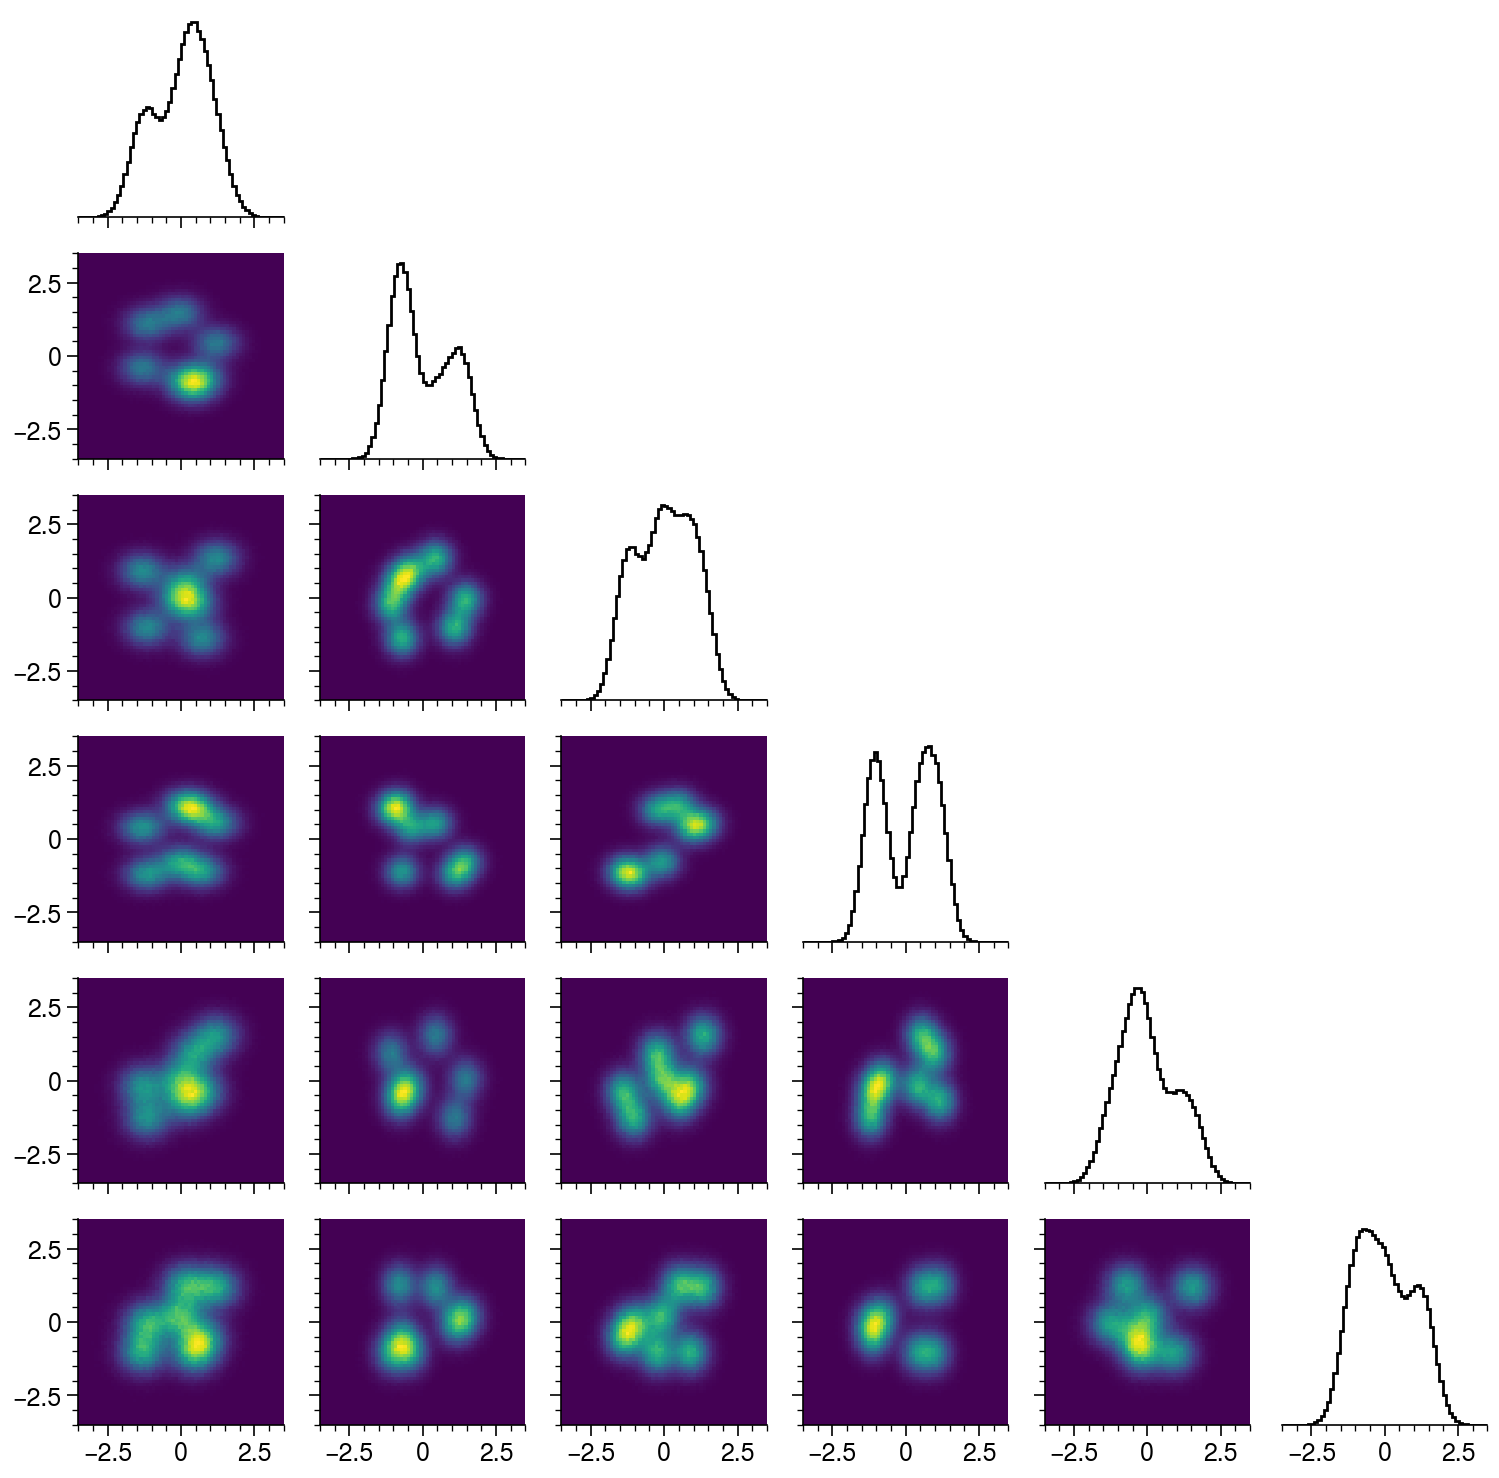

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = ndim * (ndim - 1) // 2
nbins = 64
blur = 0.0
kde = False
kde_bandwidth_frac = 1.0
axis_meas = (0, 2)

Create phase space transformations.

In [7]:
rng = np.random.default_rng(seed)
axis_meas = 0
n_meas = ndim

transfer_matrices = []
for i in range(ndim):
    j = axis_meas
    matrix = np.identity(ndim)
    matrix[i, i] = matrix[j, j] = 0.0
    matrix[i, j] = matrix[j, i] = 1.0
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

Create histogram diagnostics.

In [8]:
axis_proj = axis_meas
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

diagnostics = []
for transform in transforms:
    diagnostic = ment.diag.Histogram1D(
        axis=axis_meas,
        edges=bin_edges,
        kde=kde,
        kde_bandwidth_frac=kde_bandwidth_frac,
    )
    diagnostics.append([diagnostic])

Generate data from the source distribution.

In [9]:
projections = ment.simulate_with_diag_update(
    x_true,
    transforms,
    diagnostics,
    kde=False,
    blur=False,
    thresh=5.00e-03,
)

## Reconstruction model

In [10]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

In [11]:
samp_method = "mcmc"

if samp_method == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif samp_method == "mcmc":
    samp_burnin = 500
    samp_chains = 1000
    samp_prop_cov = np.eye(ndim) * (0.5 ** 2)
    samp_start = np.random.normal(size=(samp_chains, ndim)) * 0.50
    
    sampler = ment.MetropolisHastingsSampler(
        ndim=ndim,
        chains=samp_chains,
        start=samp_start,
        proposal_cov=samp_prop_cov,
        burnin=samp_burnin,
        shuffle=True,
        verbose=False,
        debug=False,
        noise_scale=0.10,  # slight smoothing
        noise_type="gaussian",
    )

else:
    raise ValueError

In [12]:
model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=100_000,
    mode="sample",
    verbose=True,
)

In [13]:
sampler.debug = True
model.sample(1000)
sampler.debug = False

debug 00500 acceptance_rate=0.5520


## Train

In [14]:
plot_nsamp = x_true.shape[0]

In [15]:
plot_model = Plotter(
    n_samples=plot_nsamp,
    plot_proj=[
        PlotProj1D(log=False),
        PlotProj1D(log=True),
    ],
    plot_dist=[
        PlotDistCorner(
            fig_kws=dict(figwidth=(ndim * 1.25), diag_shrink=0.80),
            limits=(ndim * [(-xmax, xmax)]),
            bins=64,
        ),
    ],
)

eval_model = ment.train.Evaluator(n_samples=plot_nsamp)

non numeric history values being saved


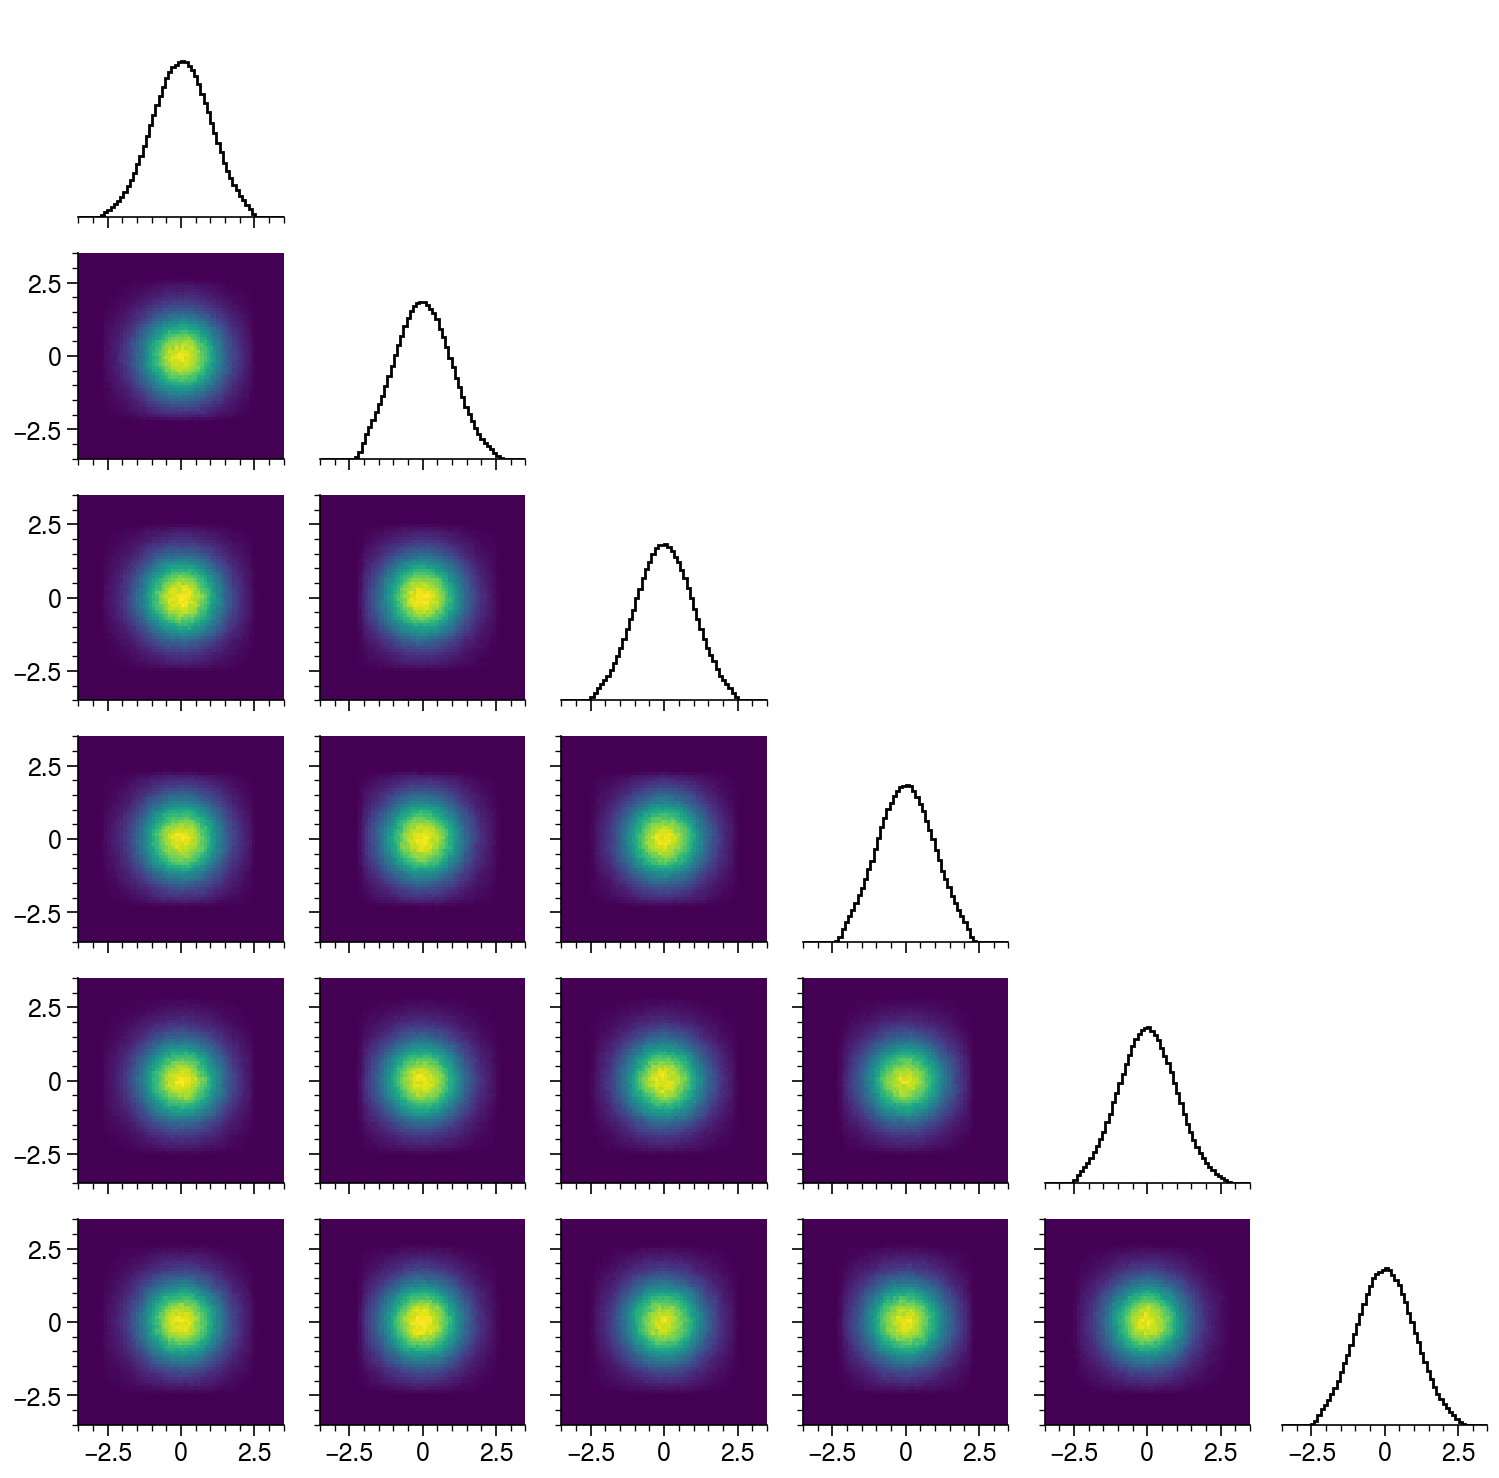

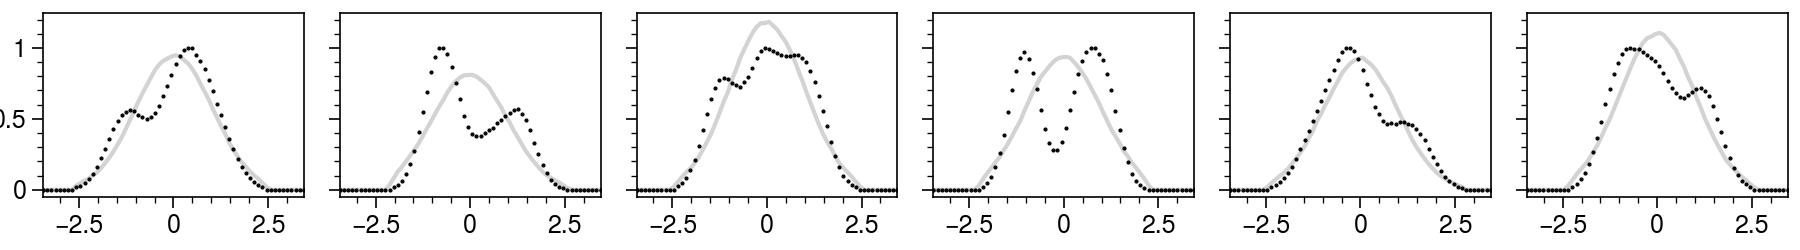

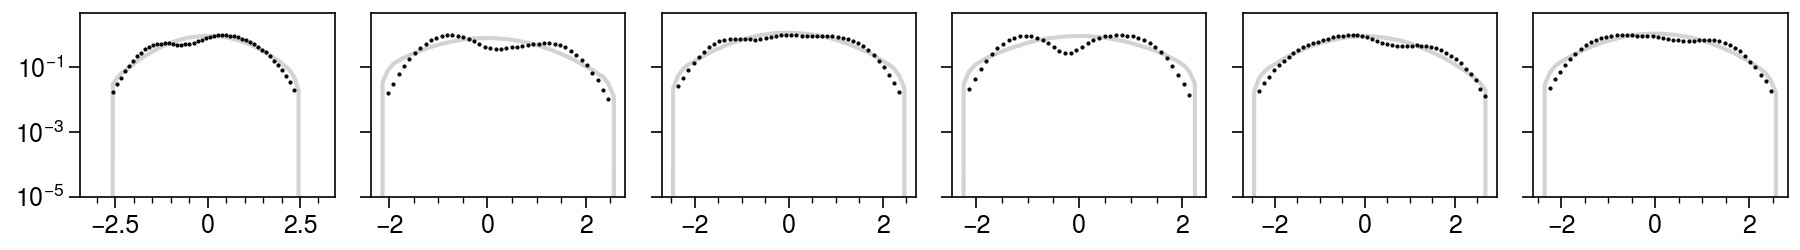

{'mean_abs_error': 0.041930281153396844}
epoch = 1
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


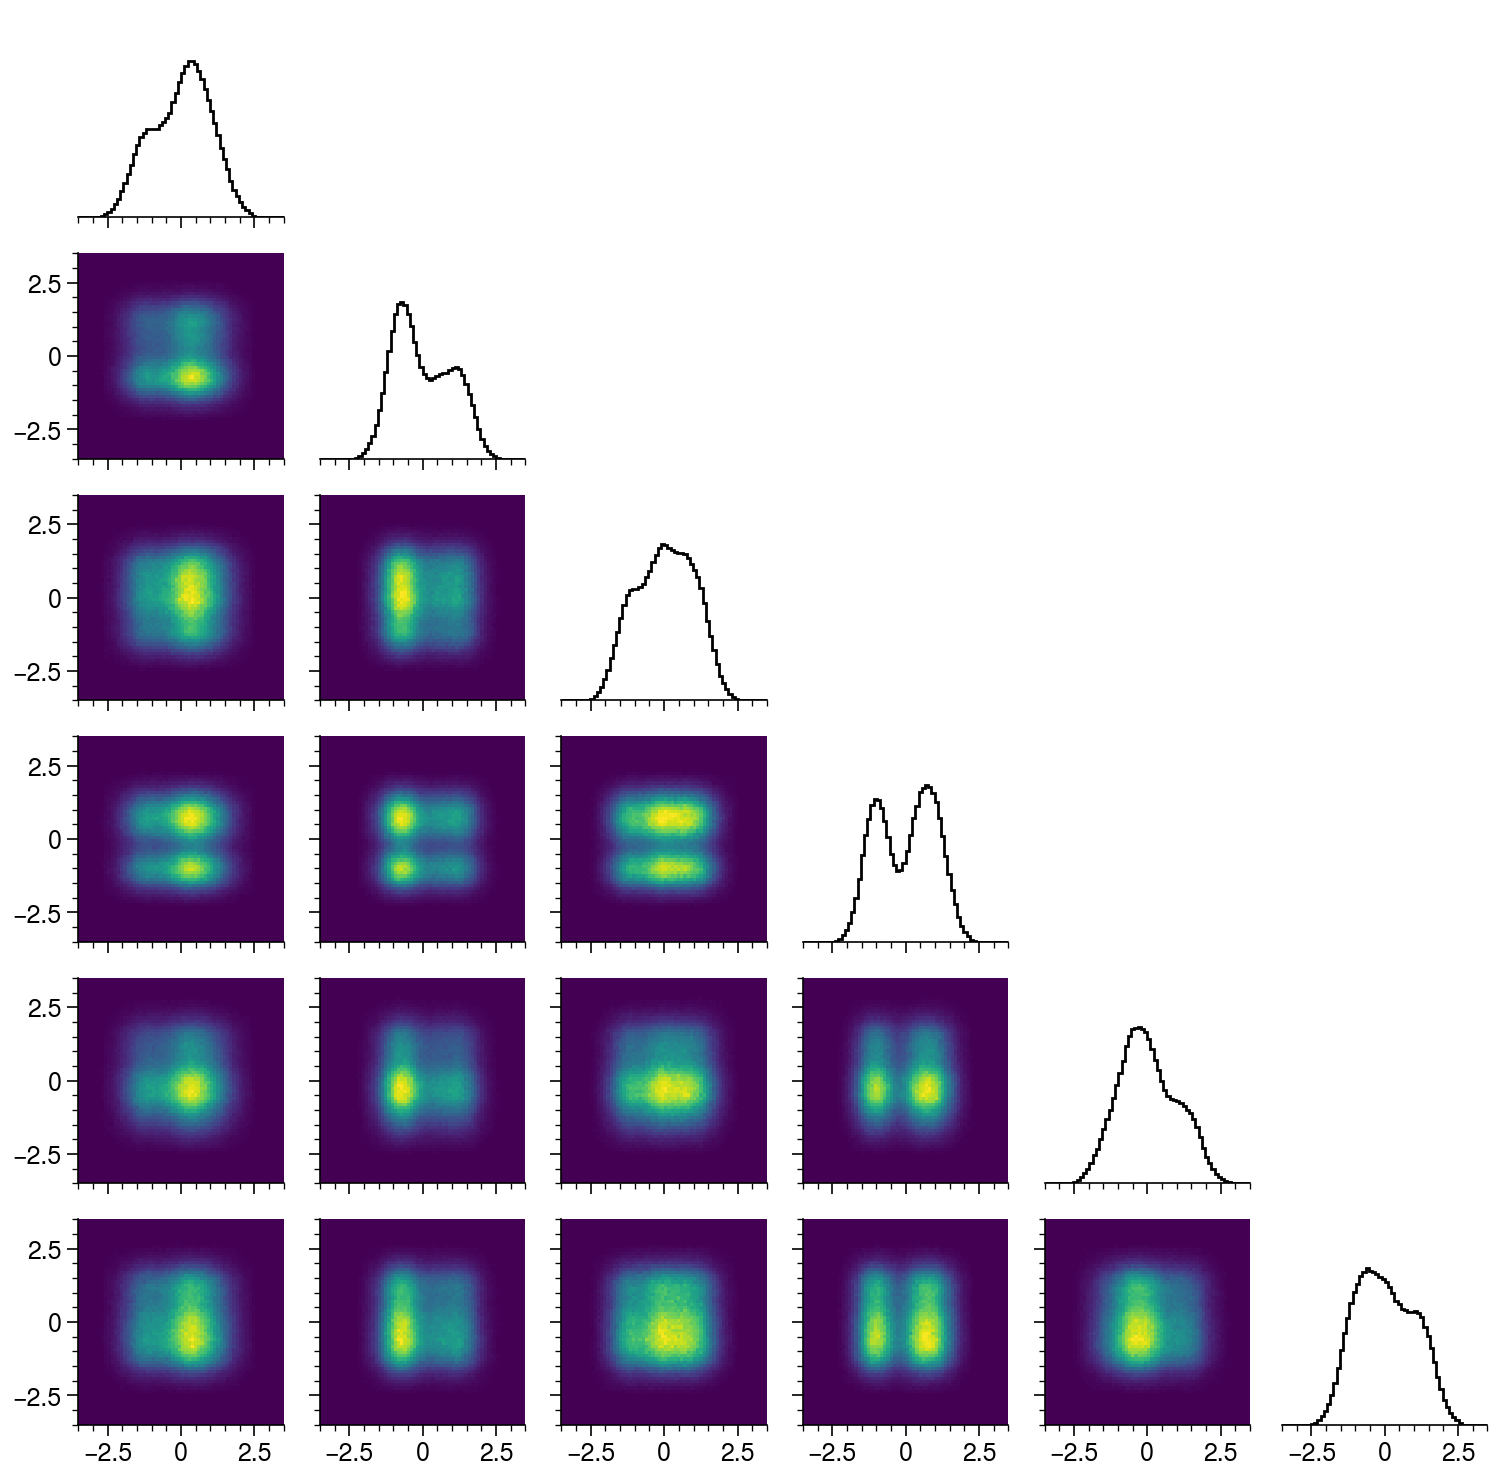

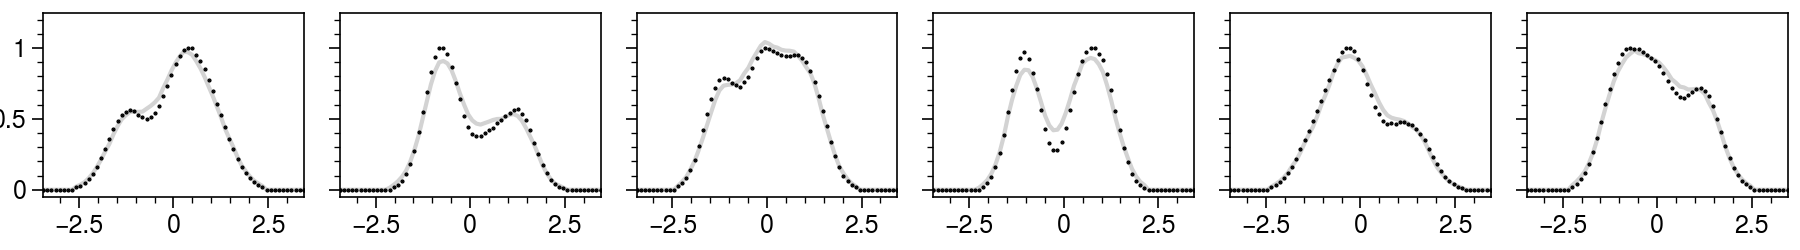

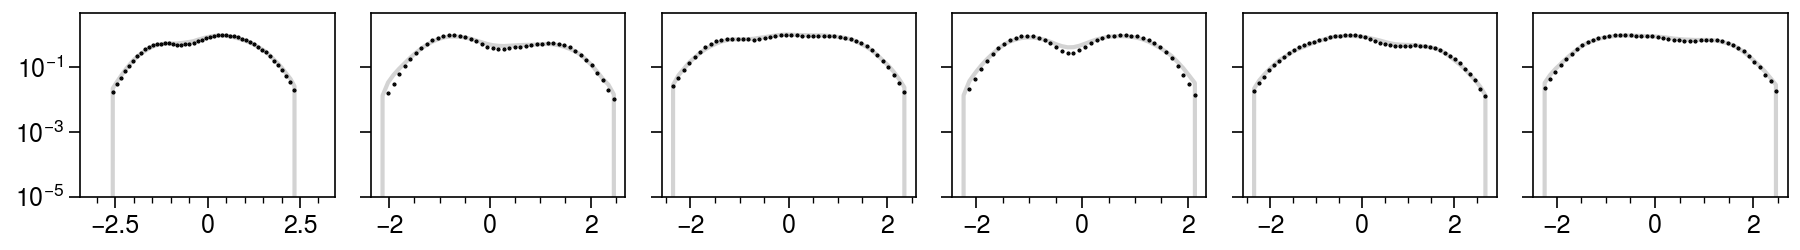

{'mean_abs_error': 0.010123685483202883}
epoch = 2
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


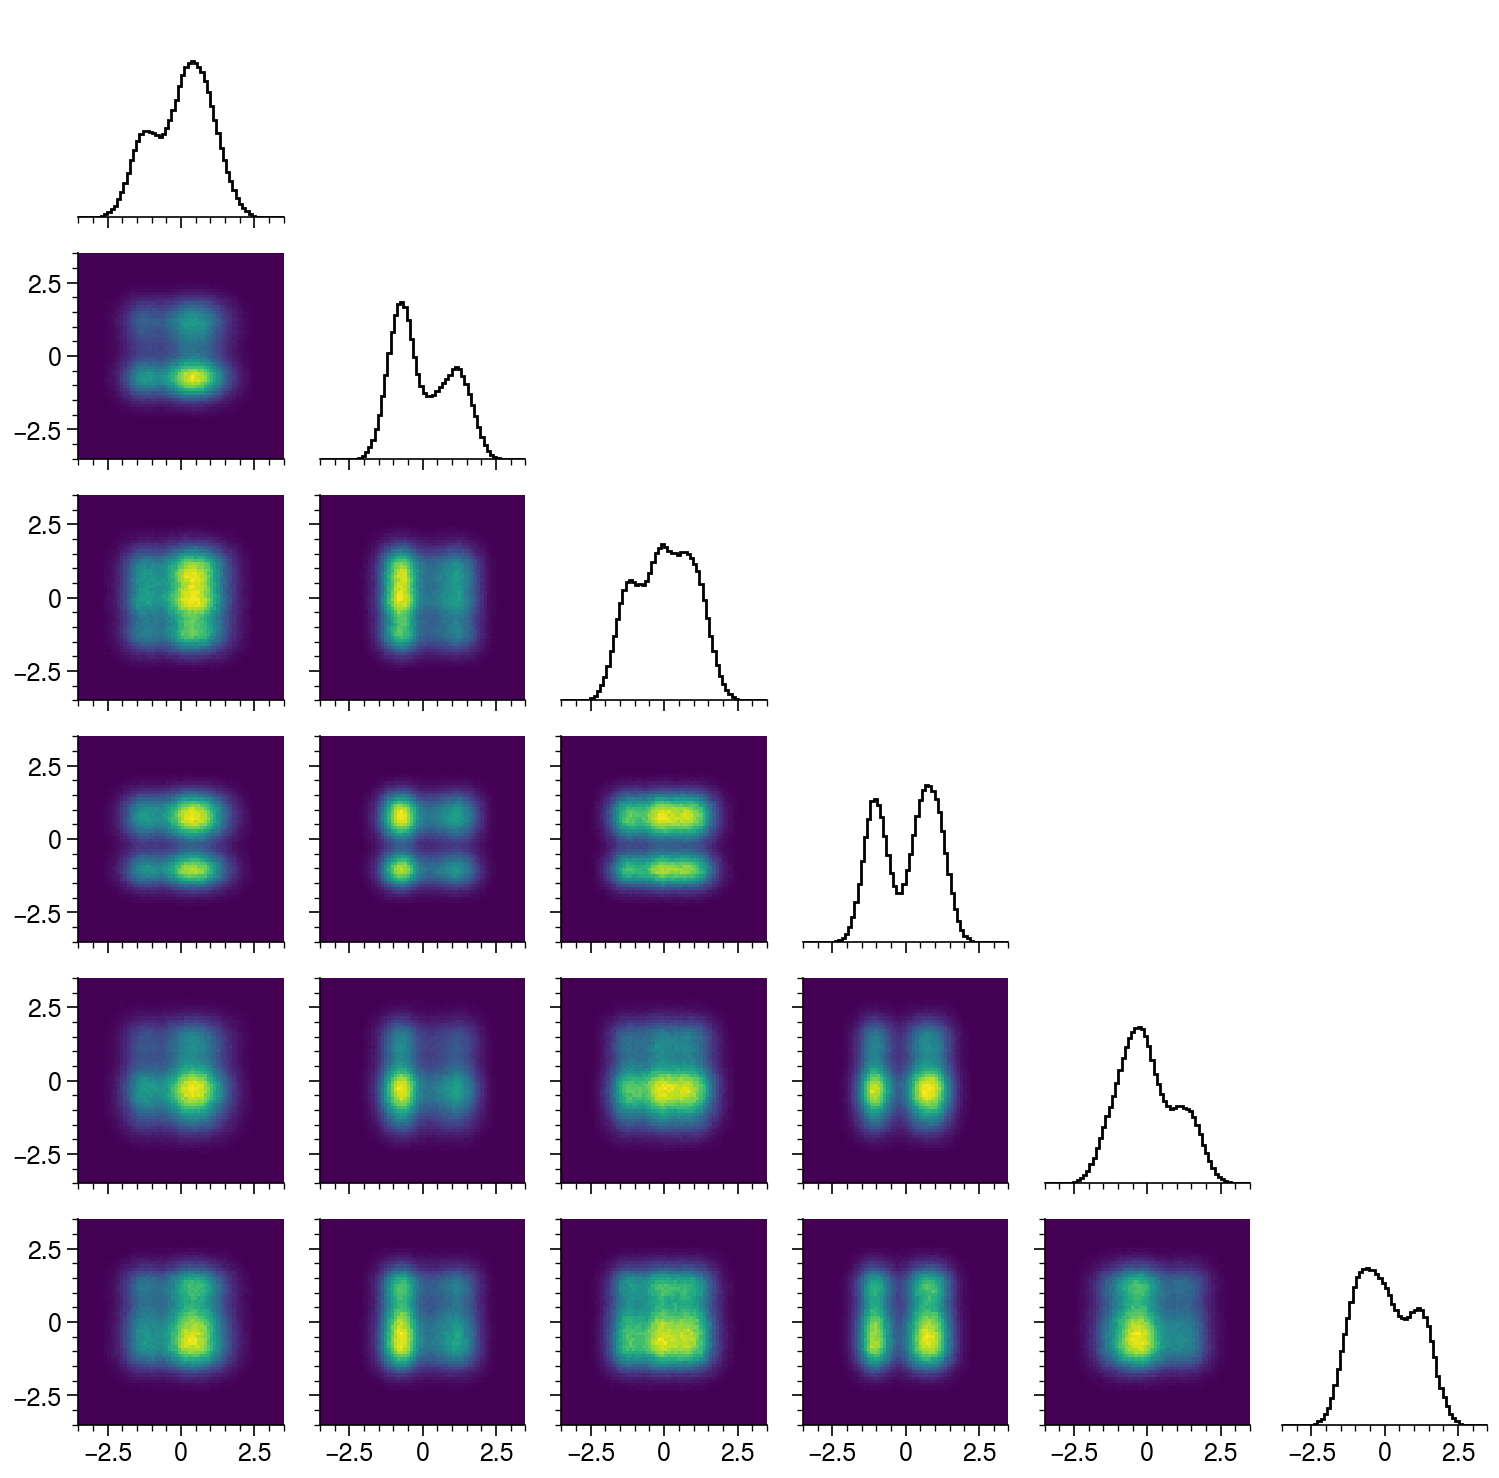

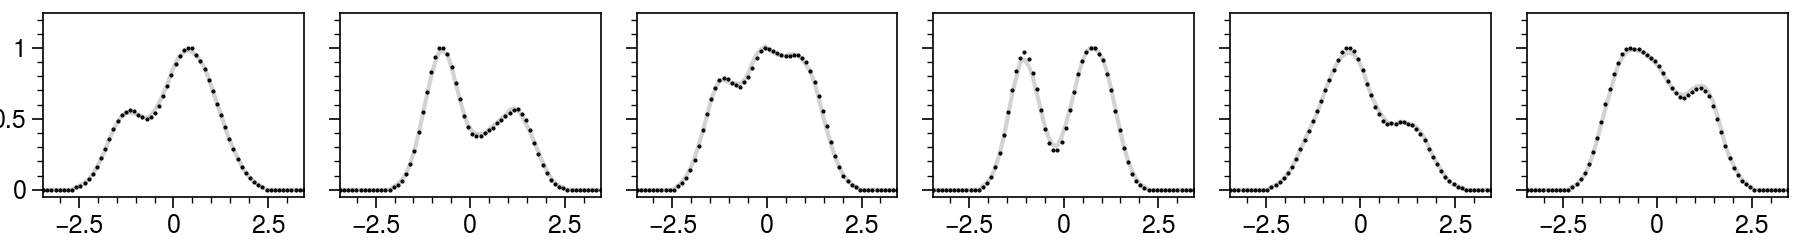

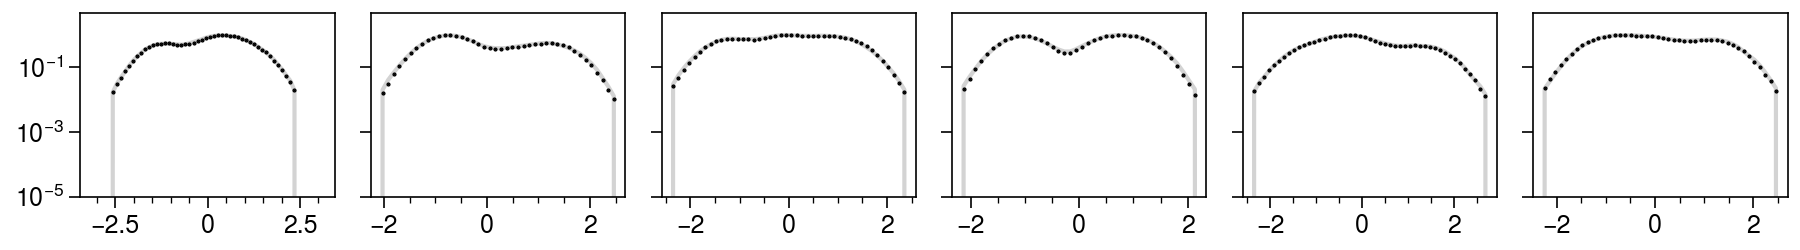

{'mean_abs_error': 0.0033062116056270952}
epoch = 3
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


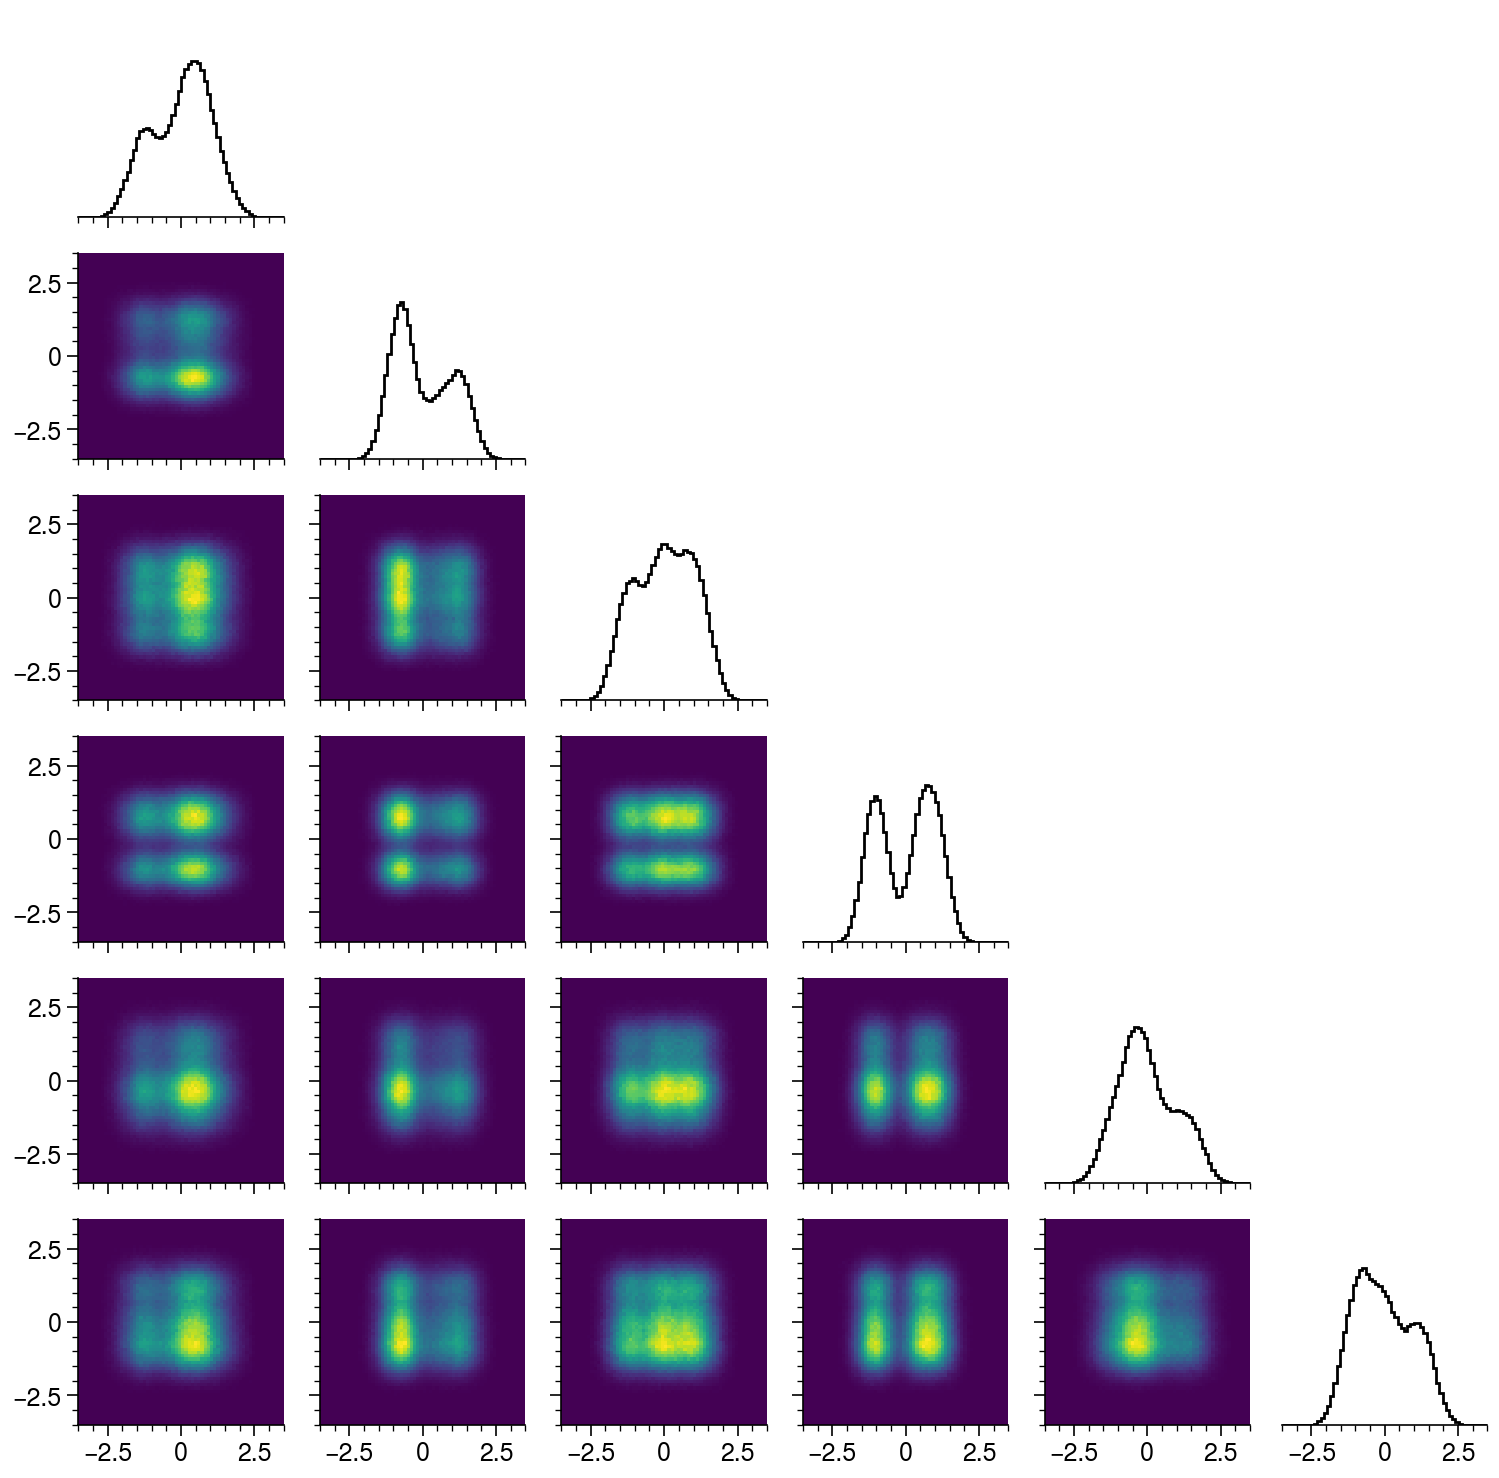

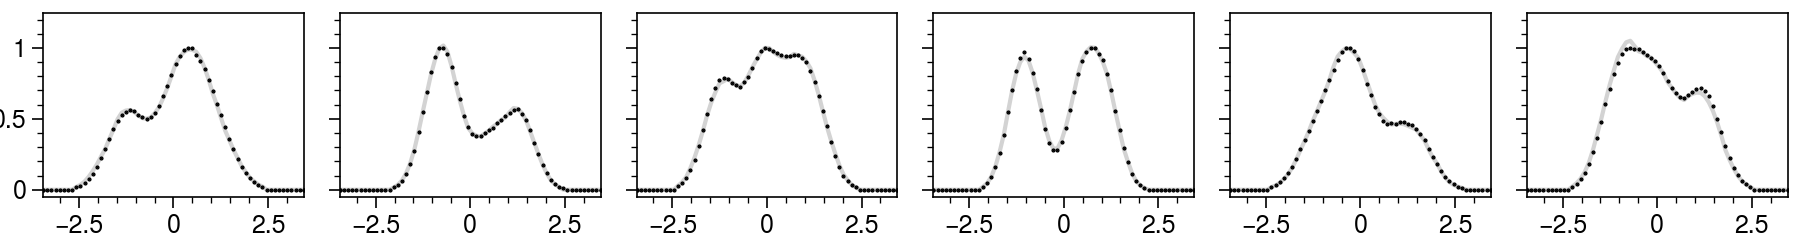

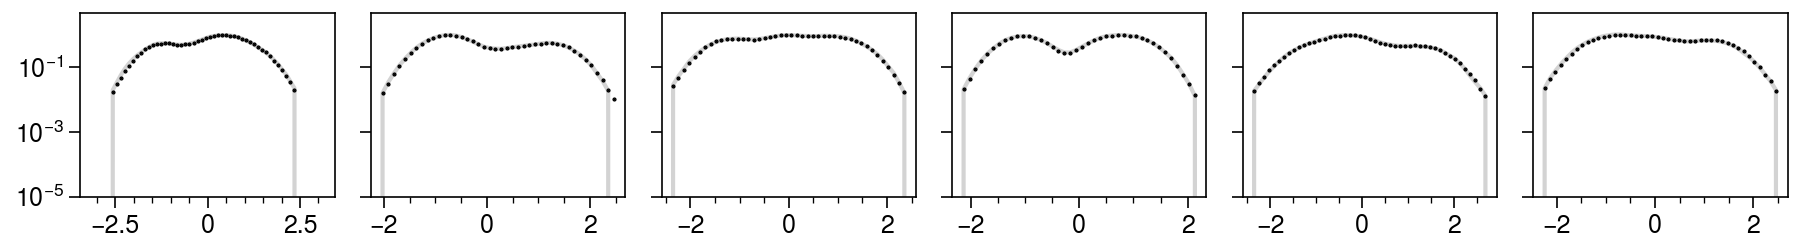

{'mean_abs_error': 0.0025763071864516964}


In [16]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=eval_model,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)

## Evaluate

In [17]:
x_pred = model.unnormalize(model.sample(1_000_000))

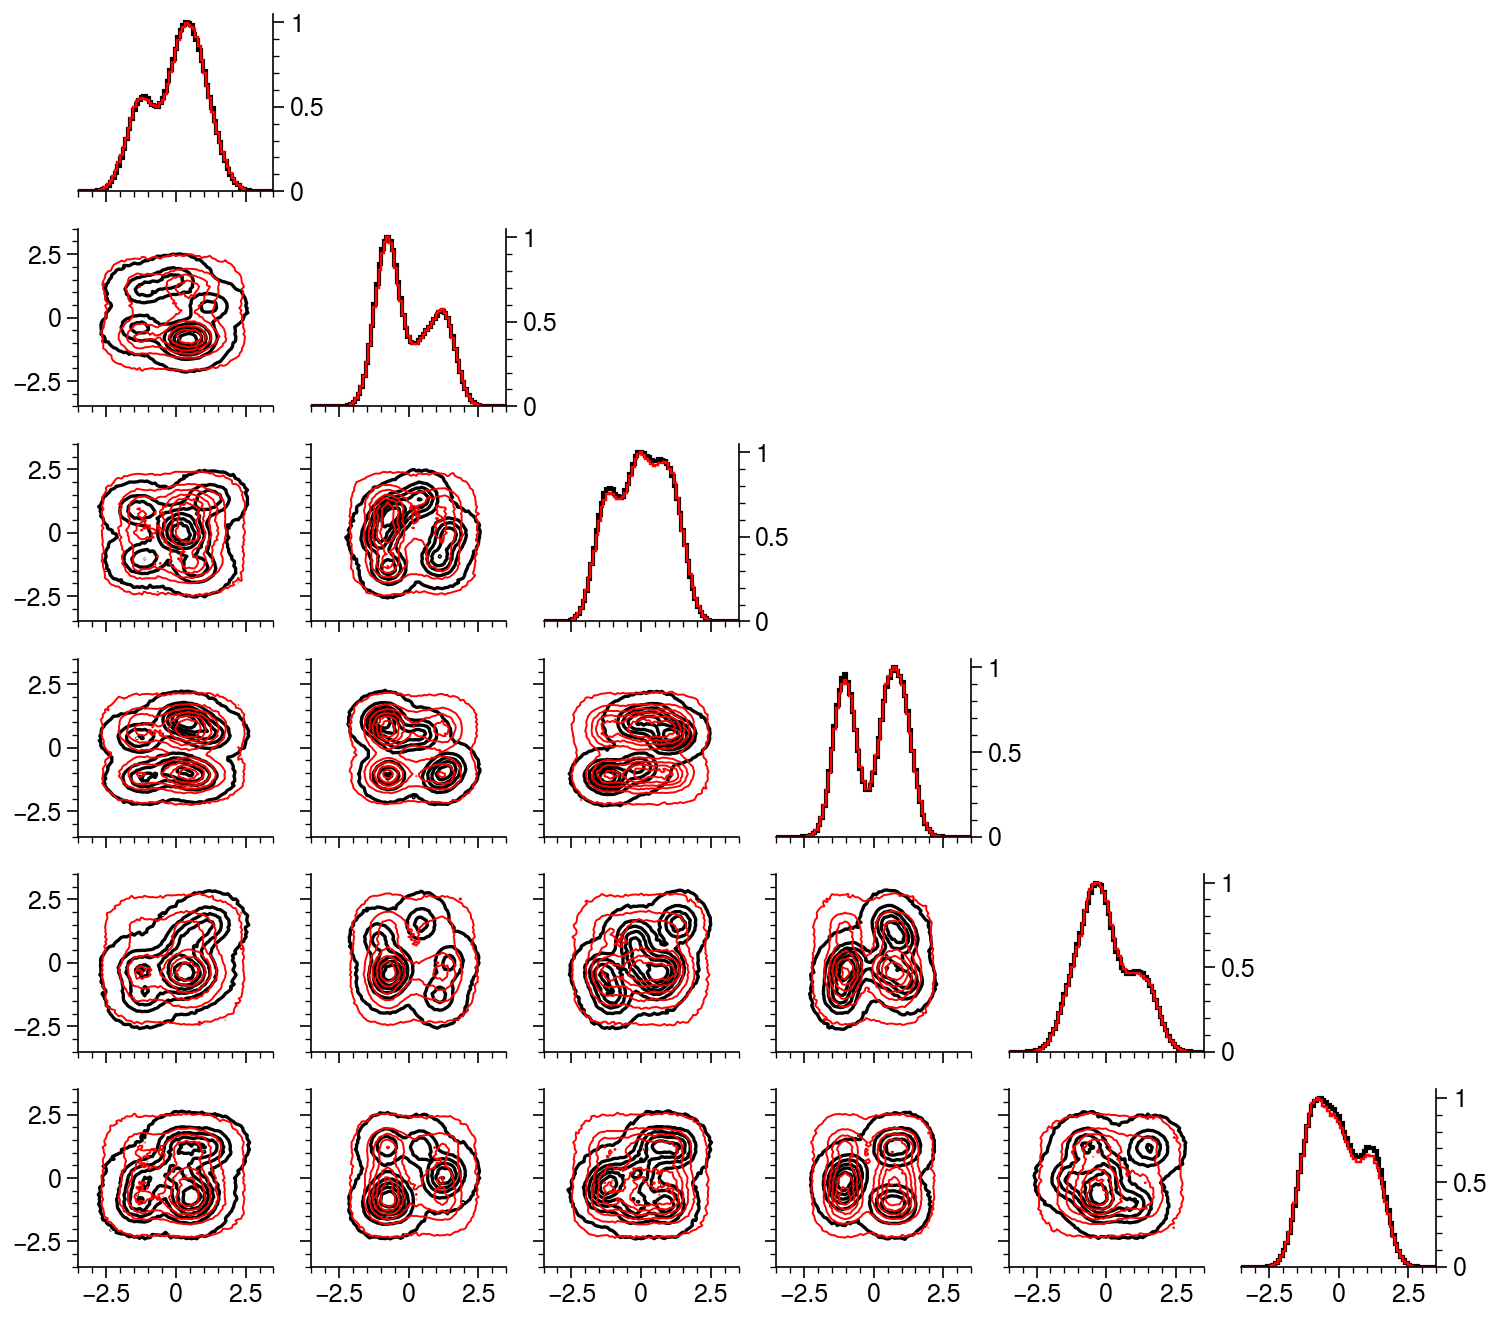

In [18]:
grid = psv.CornerGrid(ndim, figheight=(ndim * 1.10), figwidth=(ndim * 1.25), diag_rspine=True, space=1.5)
for i, x in enumerate([x_true, x_pred]):
    color = ["black", "red"][i]
    lw = [1.2, 0.7][i]
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color, lw=(lw * 1.25)),
        kind="contour",
        process_kws=dict(blur=0.0, scale="max"),
        mask=False,
        levels=np.linspace(0.01, 1.0, 7),
        color=color,
        lw=lw,
    )
plt.show()

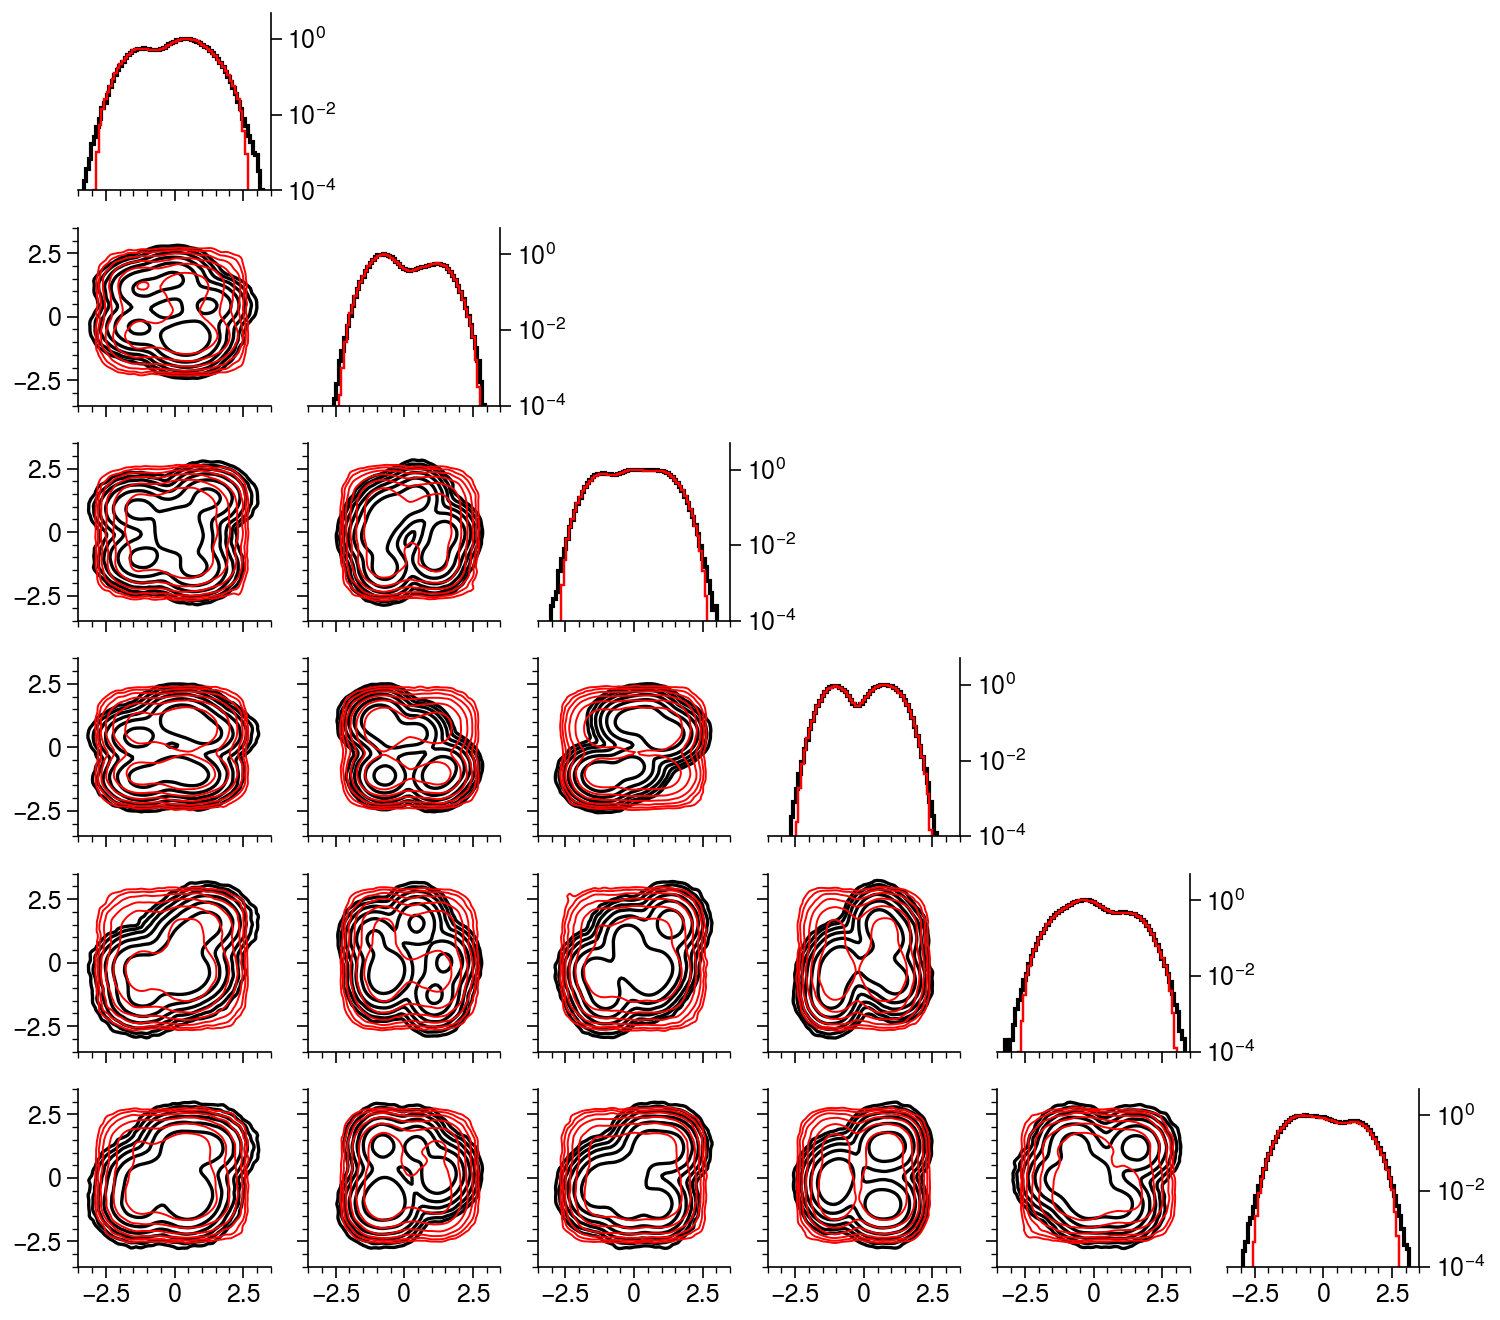

In [19]:
grid = psv.CornerGrid(ndim, figheight=(ndim * 1.10), figwidth=(ndim * 1.25), diag_rspine=True, space=1.5)
for i, x in enumerate([x_true, x_pred]):
    color = ["black", "red"][i]
    lw = [1.2, 0.7][i]
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color, lw=(lw * 1.25)),
        kind="contour",
        process_kws=dict(blur=1.0, scale="max"),
        mask=False,
        levels=(10.0 ** np.linspace(-3.0, 0.0, 7)),
        color=color,
        lw=lw,
    )
    grid.format_diag(yscale="log", yformatter="log", ymax=5.0, ymin=0.0001)
plt.show()